## Create Simulations
---

In [1]:
#import crowded.make as mk

In [2]:
import time, sys
sys.path.insert(0, '/Users/pedrohserrano/crowdED/crowded')
import simulate as cs
import method as cm
import make as mk
from pycm import *
import pandas as pd

In [3]:
tasks = [60, 100, 140]
workers = [30, 50, 80, 100]
hard_t = [0.2, 0.8]
prop = [0.2,0.8]
wpt = [5]
key = [3]

In [4]:
def _combinations(tasks, workers, hard_t, prop, wpt, key):
    table = []
    for t in tasks:
        for w in workers:
            for h in hard_t:
                for p in prop:
                    for x in wpt:
                        for k in key:
                            table.append([t, w, h, p, x, k])
    return table

In [36]:
def simulate_scenarios(tasks, workers, hard_t, prop, wpt, key, stages=2):
    sim = _combinations(tasks, workers, hard_t, prop, wpt, key)
    for idx, row in enumerate(sim):
        mk._update_progress("CrowdED simulation", (idx + 1) / len(sim))
        try:
            if stages == 2:
                df = mk.crowd_table(total_tasks=sim[idx][0], total_workers=sim[idx][1], p_hard_tasks=sim[idx][2], ptt=sim[idx][3], wpt=sim[idx][4], nk=sim[idx][5])
            else:
                df = mk.crowd_table_one_stage(total_tasks=sim[idx][0], total_workers=sim[idx][1], p_hard_tasks=sim[idx][2], ptt=sim[idx][3], wpt=sim[idx][4], nk=sim[idx][5])
            mat = ConfusionMatrix(df['true_answers'].tolist(),df['worker_answers'].tolist())
            sim[idx].insert(6, round(mat.Overall_ACC, 4))
            sim[idx].insert(7, round(mat.CrossEntropy, 4))
            sim[idx].insert(8, round(sum([i for i in mat.F1.values()]) / len([i for i in mat.F1.values()]), 4))
        except Exception:
            pass
    return sim

In [ ]:
simulations = pd.DataFrame(simulate_scenarios(tasks, workers, hard_t, prop, wpt, key, 1)).fillna(0)
simulations.columns = ['total_tasks', 'total_workers', 'proportion_hard_tasks','proportion_train_tasks', 'workers_per_task', 'total_keys','accuracy','cross_entropy','f1']

In [24]:
#simulations[simulations['accuracy'] == 0]

In [3]:
#simulations.to_csv('../data/df_crowded.csv', index=False)

--- 
### Read the experiment

In [3]:
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

In [4]:
df_sim = pd.read_csv('../../crowdED/data/20181017_13:40 - simulations.csv')

In [82]:
twostages = pd.read_csv('../../crowdED/data/20181018_18:06 - simulations.csv')

In [83]:
onestages = pd.read_csv('../../crowdED/data/20181017_13:40 - simulations.csv')

In [87]:
twostages['cross_entropy'].describe()

count    24960.000000
mean         2.218373
std          0.494647
min          1.388700
25%          1.583000
50%          2.308300
75%          2.769500
max          2.809200
Name: cross_entropy, dtype: float64

In [88]:
onestages['cross_entropy'].describe()

count    24960.000000
mean         2.218429
std          0.494888
min          1.418200
25%          1.583000
50%          2.308200
75%          2.769500
max          2.807900
Name: cross_entropy, dtype: float64

In [5]:
df_sim.sort_values('accuracy', ascending=False).head(5)

,total_tasks,total_workers,proportion_hard_tasks,proportion_train_tasks,workers_per_task,total_keys,accuracy,cross_entropy,f1
1697,60,100,0.2,0.4,3,7,0.9944,2.7124,0.9937
1445,60,90,0.2,0.2,5,7,0.9933,2.6619,0.9918
773,60,60,0.2,0.8,7,7,0.9929,2.7435,0.9912
2180,80,40,0.2,0.4,5,7,0.9925,2.7362,0.9916
1952,80,30,0.2,0.6,3,7,0.9917,2.7453,0.9914


In [105]:
#df_sim.sort_values('accuracy', ascending=False)

In [7]:
print('Number of simulations {}\nFailed simulations {}'.format(
    len(df_sim),len(df_sim[df_sim['accuracy'] == 0]) / len(df_sim)))

Number of simulations 24960
Failed simulations 0.0


In [8]:
df_sim['ratio_worker_task'] = df_sim['total_workers'] / df_sim['total_tasks']
df_sim['ratio_workers_wpt'] = df_sim['workers_per_task'] / df_sim['total_workers']
df_sim['ratio_keys_workers'] = df_sim['total_keys'] / df_sim['total_workers']
df_sim['scaled_cross_entropy'] = (df_sim['cross_entropy']-min(df_sim['cross_entropy']))/(max(df_sim['cross_entropy'])-min(df_sim['cross_entropy']))

In [9]:
df_sim.columns

Index(['total_tasks', 'total_workers', 'proportion_hard_tasks',
       'proportion_train_tasks', 'workers_per_task', 'total_keys', 'accuracy',
       'cross_entropy', 'f1', 'ratio_worker_task', 'ratio_workers_wpt',
       'ratio_keys_workers', 'scaled_cross_entropy'],
      dtype='object')

In [62]:
#sorted(df_sim['ratio_worker_task'].unique())

In [65]:
cheap = df_sim[df_sim['ratio_worker_task']<=.2]

In [68]:
top = cheap.sort_values('accuracy', ascending=False).head(1000)

In [77]:
sub = top[['accuracy','proportion_train_tasks','ratio_workers_wpt','ratio_keys_workers','scaled_cross_entropy']]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:

The following kwargs were not used by contour: 'label', 'color'



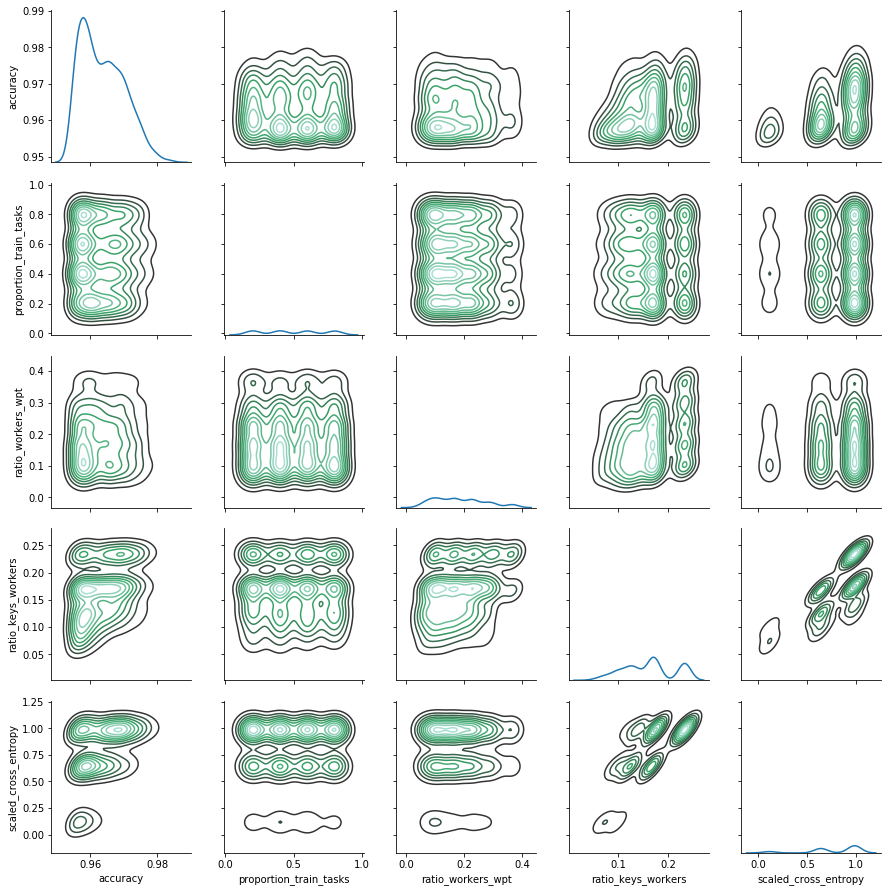

In [78]:
g = sns.PairGrid(sub)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)

In [141]:
top['ratio_worker_task'].median()

0.4166666666666667

In [143]:
top['ratio_workers_wpt'].median()

0.1

In [145]:
top['ratio_keys_workers'].mean()

0.1187426190476185

Find the optimal to recomend

In [79]:
trace1 = go.Scatter3d(
    z=sub['accuracy'].values,
    y=sub['proportion_train_tasks'].values,
    x=sub['ratio_workers_wpt'].values,
    mode='markers',
    marker=dict(
        size=6,
        color=sub['scaled_cross_entropy'].values,                # set color to an array/list of desired values
        colorscale='Bluered',   # choose a colorscale
        opacity=0.5
    )
)

In [80]:
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [81]:
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

Optimal range of number of workers and number of workers per task to perform the best accuracy

Where the accuracy declines or stablelize adding number of workers

compare 3layer, workers, tasks and performance(true answer rate)